In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import warnings
import cmocean as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec, ticker
from scipy.ndimage.filters import gaussian_filter
warnings.filterwarnings('ignore')
import seawater as sw
from dask.diagnostics import ProgressBar
from datetime import datetime
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature


/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [2]:
fsource = sorted(glob.glob('/home/bruno/git/globcolour/gsm-chl/*.nc'))

In [3]:
source   =  [xr.open_dataset(i, chunks={}) for i in fsource]
time=[datetime.strptime(fi.period_start_day, '%Y%m%d') for fi in source]
source = xr.concat(source, dim='time')
source = source.assign_coords(time=time)
source.close

<bound method DataWithCoords.close of <xarray.Dataset>
Dimensions:     (lat: 481, lon: 481, time: 8349)
Coordinates:
  * lat         (lat) float32 -19.98 -20.02 -20.06 -20.1 ... -39.9 -39.94 -39.98
  * lon         (lon) float32 -60.02 -59.98 -59.94 -59.9 ... -40.1 -40.06 -40.02
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2020-12-31
Data variables:
    CHL1_mean   (time, lat, lon) float32 dask.array<chunksize=(1, 481, 481), meta=np.ndarray>
    CHL1_flags  (time, lat, lon) float32 dask.array<chunksize=(1, 481, 481), meta=np.ndarray>
    CHL1_error  (time, lat, lon) float32 dask.array<chunksize=(1, 481, 481), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour daily SeaWiFS product
    product_name:               L3m_19980101__975627288_4_GSM-SWF_CHL1_DAY_00.nc
    product_type:               day
    product_version:            2018.4
    product_level:              3
    ...                         ..

In [ ]:
#source

In [ ]:
# print('atributos:')
# source.attrs

In [12]:
### Load a  CHL dataset - open time serie of ESA/CCI Colored Dissolved organic Matter L3 daily means ###
#1 - gsm/cci
# chl_file = xr.open_mfdataset('/home/bruno/git/CMEMS/chl_data/chl*')
# chl_file = chl_file.reindex()

# chl_file.close()

#2 - occci

### Load a  CHL- open time serie of esacci clorophyll data (reference) ###

file = xr.open_mfdataset('/home/bruno/git/CMEMS/oc-cci-chl/oc*') #adress of data in my desktop
chl_file = file.reindex()

chl_file.close()

In [13]:
chl_file

<xarray.Dataset>
Dimensions:       (time: 8024, latitude: 481, longitude: 482)
Coordinates:
  * latitude      (latitude) float64 -20.02 -20.06 -20.1 ... -39.98 -40.02
  * time          (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2019-12-31
  * longitude     (longitude) float64 -60.02 -59.98 -59.94 ... -40.02 -39.98
Data variables:
    grid_mapping  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    CHL           (time, latitude, longitude) float32 dask.array<chunksize=(359, 481, 482), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                               CF-1.7
    FROM_ORIGINAL_FILE__Metadata_Conventions:  Unidata Dataset Discovery v1.0
    keywords:                                  satellite,observation,ocean,oc...
    summary:                                   Data products generated by the...
    history:                                   Source data were: NASA OBPG Se...
    netcdf_file_type:                          NETCDF4_CLASSIC
    ...                                        ...
    start_date:                                2020-12-31
    start_time:                                00:00:00 UTC
    stop_date:                                 2020-12-31
    stop_time:                                 23:59:00 UTC
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    source:

#### spatial mask using .sel and .where

In [4]:
# LOAD BATHYMETRY DATA

bat_dado = xr.open_dataset('/home/bruno/git/CMEMS/gebco/gebco_2020_n-20.0_s-40.0_w-60.0_e-40.0.nc')

In [5]:
CHL1_set = source.CHL1_mean.sel(lon=slice(-48.0, -40.0), lat=slice(-22.0, -25))

In [14]:
#CHL1_set = source.CHL1_mean.sel(lon=slice(-50.0, -40.0), lat=slice(-21.0, -28))
#CHL_set = chl_file.CHL.sel(lon=slice(-50.0, -40.0), lat=slice(-21.0, -28))
CHL_set = chl_file.CHL.sel(longitude=slice(-48.0, -40.0), latitude=slice(-22.0, -25))

In [15]:
mask_bat1 = bat_dado.interp({'lon':CHL1_set.lon, 'lat':CHL1_set.lat}).elevation


In [19]:
#mask_bat1 = bat_dado.interp({'lon':CHL1_set.lon, 'lat':CHL1_set.lat}).elevation
#mask_bat = bat_dado.interp({'lon':CHL_set.lon, 'lat':CHL_set.lat}).elevation
mask_bat = bat_dado.interp({'lon':CHL_set.longitude, 'lat':CHL_set.latitude}).elevation
# dado.close()
# mask_chl1.close()

In [16]:
#print(CHL1_set)

### shelf selection
###### series

In [ ]:
#long time serie

In [17]:
shelf = CHL1_set.where((mask_bat1>-200)&(mask_bat1<-10))
shelf_serie = shelf.mean(['lat','lon'])

In [20]:
shelf_cci = CHL_set.where((mask_bat>-200)&(mask_bat<-10))
shelf_scci = shelf_cci.mean(['latitude','longitude'])

#test =shelf_scci.compute()

In [24]:
test=shelf_scci.compute()

Text(0.5, 1.0, 'CHL1-GSM')

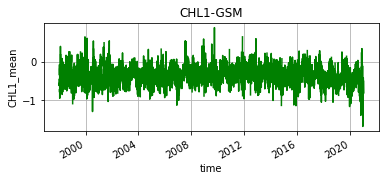

In [9]:
plt.figure(figsize=(6,2))
np.log10(shelf_serie).plot(x='time', color='green',linestyle='-')
plt.grid(True)
plt.title('CHL1-GSM')

Text(0.5, 1.0, 'CHL-OC/CCI')

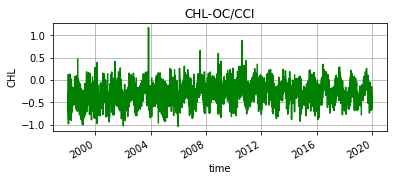

In [25]:
plt.figure(figsize=(6,2))
np.log10(test).plot(x='time', color='green',linestyle='-')
plt.grid(True)
plt.title('CHL-OC/CCI')

Text(0.5, 1.0, 'CHL in SBB from distinct oc algorithm')

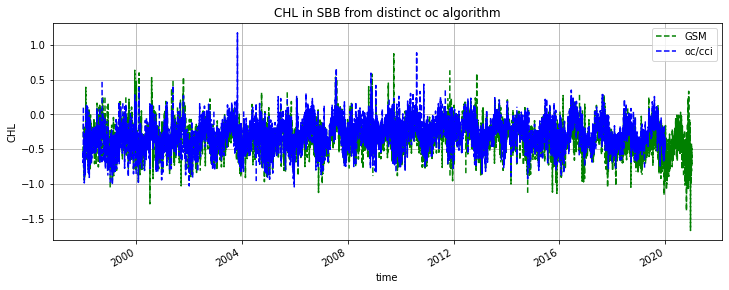

In [33]:
plt.figure(figsize=(16,4))
np.log10(shelf_serie).plot(x='time', label='GSM', color='green',linestyle='--')
np.log10(test).plot(x='time', label='oc/cci', color='blue',linestyle='--')
plt.legend()
plt.grid(True)
plt.title('CHL in SBB from distinct oc algorithm')

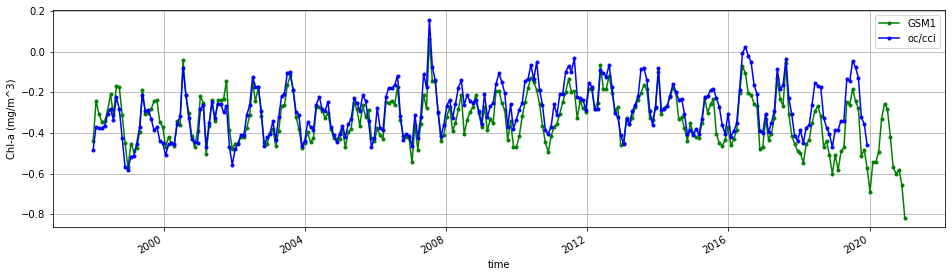

In [35]:
#resample

plt.figure(figsize=(16,4))
np.log10(shelf_serie).resample(
         {'time':'30D'}
     ).mean().plot(x ="time" , label='GSM1', color='green',marker='.',linestyle='-')
np.log10(shelf_scci).resample(
         {'time':'30D'}
    ).mean().plot(x ="time" , label = 'oc/cci', color='blue',marker='.',linestyle='-')
plt.ylabel('Chl-a (mg/m^3)') 
plt.grid(True)
plt.legend()
plt.show()
#plt.title('CHL1-GSM - clorophyll mass monthly mean time serie')


In [ ]:
#corr

#### make a hovmoller

In [ ]:
#------------------------- função montar uma matrix para um vetor de batimetria "suave"----------------------------------------------------

def extract_bat(lon,lat,topo,level,flevel):
    CT = plt.contour(gaussian_filter(lon,flevel),
                     gaussian_filter(lat,flevel),gaussian_filter(topo,flevel),
                     [level],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    # CT = plt.contour(lon,lat,topo,[-100],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    lli = []
    for i in range(len(CT.allsegs[0])):
        print(CT.allsegs[0][i].shape[0])
        lli.append(CT.allsegs[0][i].shape[0])
        
    lbat = CT.allsegs[0][np.argmax(lli)]
    print('Maior shape é'.format(CT.allsegs[0][np.argmax(lli)].shape))

    return lbat[:,0],lbat[:,1]

In [ ]:
def hov_ext_chl1_dist(x,y,subset_file):

    hov_chl1 = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_chl1.append(subset_file.sel(lon=xi[i], lat=yi[i], method='nearest'))

    hov_chl1 = xr.concat(hov_chl1,dim='distance')
    hov_chl1 = hov_chl1.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_chl1 = hov_chl1.compute()
        
    #hov_chl1 = hov_chl1.interpolate_na('distance').interpolate_na('time')
    
    return hov_chl1

In [ ]:
#--- SELEÇÃO SEÇÕES DE ACORDO COM A BATIMETRIA SUAVE ---- #


In [ ]:
xbat,ybat,zbat = mask_bat.lat.values,mask_bat.lon.values,mask_bat.values

x, y =  extract_bat(ybat, xbat, zbat, level = -80, flevel = 8) # SELECIONANDO VETORES
# x_1, y_1 = extract_bat(ybat, xbat, zbat, level = -100, flevel = 10)
# x_2, y_2 = extract_bat(ybat, xbat, zbat, level = -150, flevel = 10)
#x_3, y_3 = extract_bat(ybat, xbat, zbat, level = -200, flevel = 10)


x,y = x[::10],y[::10]
# x_1,y_1 = x_1[::10],y_1[::10] 
# x_2,y_2 = x_2[::10],y_2[::10]
x_3,y_3 = x_3[::10],y_3[::10]

In [ ]:
#CHL1_set.time

In [ ]:
shelf.time.coords

In [ ]:
hov_CHL = hov_ext_chl1_dist(x,y,shelf)
# hov_CHL_1 = hov_ext_chl1_dist(x_1,y_1,shelf)
# hov_CHL_2 = hov_ext_chl1_dist(x_2,y_2,shelf)
#hov_CHL_3 = hov_ext_chl1_dist(x_3,y_3,shelf)

In [ ]:
xr.corr(hov_CHL, hov_CHL_3, dim="time")

In [ ]:
#hov_CHL

In [ ]:
plt.figure(figsize=(15,3), dpi =300)
np.log10(hov_CHL).resample({'time':'30D'}).mean().plot.contourf(
    y='lat', vmin= -0.8 , vmax= 0.5, cmap= 'Spectral_r',robust=True)
#plt.xlabel('month')
plt.ylabel('Latitude')
plt.title('CHL1')
#plt.tight_layout()

# plt.figure(figsize=(15,3), dpi =300)
# np.log10(hov_CHL_3).resample({'time':'30D'}).mean().plot.contourf(
#     y='lat',  cmap= 'Spectral_r',robust=True)
# #plt.xlabel('month')
# plt.ylabel('Latitude')
# plt.title('CHL1')
# #plt.tight_layout()